# Task 1: Movie Recommendation
(maximum achievable points: 30)

In this task you will work with the “MovieLens 1M” data set [3], a benchmark dataset for building recommender systems. 

Your goal is to train a machine learning model for predicting how users would rate different movies based on user and movie features.

## Subtask 1: Data Loading and Data Preparation
(5 points)
Download the dataset from the link provided in the bibliography and unzip it.   
Read the included README file. Write functions to load and process the user information,  
the movie information and the ratings from users.dat, movies.dat and ratings.dat, respectively,   
and construct training data (feature vectors from user and movie data, as well as targets from   
the ratings) such that based on this data you can train a classifier to predict a user's movie ratings. Consider the following points:  
• The ratings are given as 1-star to 5-star ratings. Consider those as classes 1, . . . , 5.  
• Whenloadingthedataforprocessing,thinkahead(readthedescriptionofallsubtasks first) as you will need to construct feature vectors from the data which will then be   processed by various machine learning models. In particular, the ratings correspond to labels we want to predict and the features you construct from the user and   movie data should contain useful information for predicting that label.  
• Remove all users which have rated less than 100 movies.  
• Split the data into training and test data. Construct the test data from all the ratings  
of users with user ids 1, . . . , 1000 (unless a user was removed). Use the remaining ratings to construct the training data.  


□ In the report, describe the feature vectors you created. Explain how you represented features and why?  
□ How many samples does your training and test data contain?  
Hint 1: You can ignore the zip-code (in the user information) and the time stamp (in  
the ratings information) for simplicity.  
Hint 2: Store intermediate results. For instance, after loading the user file and bringing it into a suitable format for further processing, store it. This can help you minimize processing time.  
Remark: The specific way in which we are using the data here is not the most common one. Hence, when reading literature on recommender systems don't be confused.  



In [90]:
# imports
import pandas as pd
import os
from sklearn.preprocessing import TargetEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer    
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from _stochastic_optimizers import AdamOptimizer
from sklearn.metrics import accuracy_score

import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torchmetrics import HingeLoss

In [91]:
# loading data, for df_movies drop Title as its useless
data_dir = 'ml-1m/'

user_cols = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]
df_users = pd.read_csv(
    os.path.join(data_dir, 'users.dat'), sep='::', names=user_cols, engine='python'
    )

movies_cols = ["MovieID", "Title", "Genres"]
df_movies = pd.read_csv(
    os.path.join(data_dir, 'movies.dat'), 
    sep='::', names=movies_cols, engine='python', encoding="ISO-8859-1" # throws an error otherwise
    )
df_movies = df_movies.drop('Title', axis=1)

ratings_cols = ["UserID", "MovieID", "Rating", "Timestamp"]
df_ratings = pd.read_csv(
    os.path.join(data_dir, 'ratings.dat'), 
    sep='::', names=ratings_cols, engine='python'
    )

In [92]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [93]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   int64 
 1   Genres   3883 non-null   object
dtypes: int64(1), object(1)
memory usage: 60.8+ KB


In [94]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [95]:
# first delete everything unnessesary
df_ratings = df_ratings.drop(columns=['Timestamp'])
df_users = df_users.drop(columns=['Zip-code'])

In [96]:
# delete all users with less than 100 ratings
include = df_ratings.groupby('UserID').MovieID.count().reset_index()
include = include[include['MovieID'] > 100]
df_ratings = df_ratings[df_ratings.UserID.isin(include.UserID.unique())]
df_users = df_users[df_users.UserID.isin(include.UserID.unique())]

In [97]:
# most common map for gender
df_users.Gender = df_users.Gender.map({'M': 1, 'F': 0}) 
df_users.Gender = df_users.Gender.astype(int)

In [98]:
# now, I could do one-hot encoding, but I wont, as it would produce 21 + 7 = 28 features for users
# for users I will use Target encoder, 
# for movies - one-hot encoding as one movie can be in few genres 
# (in sklearn it is called MultiLabelBinarizer)

# !!! I didnt do something like "avarage user rating" on purpose as it could lead to data leakage
# It could be done if we use timestamp variable, but as its said to drop it, I dont do it
df = (
    df_ratings
    .merge(df_movies, on='MovieID', how='left').drop('MovieID', axis=1)
    .merge(df_users, on='UserID', how='left')
)

mlb = MultiLabelBinarizer()
df = pd.concat([
    df.drop('Genres', axis=1),
    pd.DataFrame(mlb.fit_transform(df.Genres.str.split('|')), columns=mlb.classes_, index=df.index)
    ], axis=1)

# from task desccription:
X_train = df[df.UserID > 1000].drop('Rating', axis=1).drop('UserID', axis=1)
X_test = df[df.UserID <= 1000].drop('Rating', axis=1).drop('UserID', axis=1)
y_train = df[df.UserID > 1000].Rating
y_test = df[df.UserID <= 1000].Rating

In [202]:
X_train

,Gender,Age,Occupation,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
127625,1,25,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
127626,1,25,4,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
127627,1,25,4,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127628,1,25,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127629,1,25,4,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843697,1,25,6,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
843698,1,25,6,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
843699,1,25,6,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
843700,1,25,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [203]:
# column transformer, will be used when building pipeline
ct = ColumnTransformer([
    ('onehot', TargetEncoder(), ["Age", "Occupation"]),
],remainder='passthrough')

## Subtask 2: Basic Movie Recommendation
(15 points)
In this task you have train different classifiers for predicting a user's ratings from con- catenated user-movie information, select good hyper-parameters for them, and evalu- ate their performance.   
In particular, consider linear SVMs (sklearn.svm.LinearSVC)1, and multi-layer perceptron classifiers (sklearn.neural_network.MLPClassifier). For the SVM, tune the regularization parameter C. For the MLP classifiers, tune the number of hidden layers and their respective sizes (hidden_layer_sizes). For tuning the hyper-parameters, use cross-validation (of course, only on the training data). Try at least 3 different hyper-parameters for the SVM and the multi-layer-perceptron classi- fiers, respectively.  
□ Report which models you tried (e.g., state the considered hyper-parameter values) and which models gave you the best prediction accuracy.  
□ State the best performing models' performances (SVM and multi-layer-perceptron) on the test set.  
□ What is the best performance that can be achieved by making a constant prediction, i.e., always predicting some fixed c ̄ ∈ {1, . . . , 5}?  


In [252]:
# now combine  so we dont have to manually concat data after transformation
svc_pipe = Pipeline(steps=[
    ('transformer', ct),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC())
])

In [253]:
# cross validation with grid search
param_grid = {
    "classifier__C": [0.01, 0.1 , 1.],
}

searchCV = GridSearchCV(svc_pipe, cv=5, param_grid=param_grid)
searchCV.fit(X_train, y_train)

/Users/khodosevichleo/Desktop/HauptUni/1sem/IML/PA/PA3/PA3/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1651: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         TargetEncoder(),
                                                                         ['Age',
                                                                          'Occupation'])])),
                                       ('scaler', StandardScaler()),
                                       ('classifier', LinearSVC())]),
             param_grid={'classifier__C': [0.01, 0.1, 1.0]})

In [254]:
best_C = searchCV.best_params_
print(f"best params {searchCV.best_params_}")

best params {'classifier__C': 0.01}


In [255]:
# retrain with best param and evaluate on test set
test_score = svc_pipe.set_params(**best_C).fit(X_train, y_train).score(X_test, y_test)

In [256]:
print(f"Cross validation score {searchCV.best_score_:.2f} Test score: {test_score:.2f}")

Cross validation score 0.35 Test score: 0.35


In [244]:
# Now we combine 
mlp_pipe = Pipeline(steps=[
    ('transformer', ct),
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier())
])

In [235]:
# commented it as it takes too long, you can check that its right by uncommenting it

param_grid = {
    "classifier__hidden_layer_sizes": [(50, 1), (100, 1), (100, 2)],
}

searchCV = GridSearchCV(mlp_pipe, cv=5, param_grid=param_grid)
searchCV.fit(X_train, y_train)

best_layer_size = searchCV.best_params_['classifier__hidden_layer_sizes']
best_layer_size

(100, 2)

In [243]:
best_params = searchCV.best_params_
best_score = searchCV.best_score_
print(f"best params {best_params}, best score {best_score}")

best params {'classifier__hidden_layer_sizes': (100, 2)}, best score 0.3560762312806153


In [245]:
# retrain with best param and evaluate on test set

test_score = mlp_pipe.set_params(**best_params).fit(X_train, y_train).score(X_test, y_test)

In [246]:
print(f"Cross validation score {best_score:.4f} Test score: {test_score:.4f}")

Cross validation score 0.3561 Test score: 0.3618


In [103]:
# if we predict only one class:
for c in range(1, 6):
    print(f"Class {c}: accuracy = {accuracy_score(np.zeros(y_test.shape)+c, y_test)}")

Class 1: accuracy = 0.0543232125367287
Class 2: accuracy = 0.11270519098922625
Class 3: accuracy = 0.2699862879529873
Class 4: accuracy = 0.3534417238001959
Class 5: accuracy = 0.2095435847208619


## Subtask 3: Classifier Evaluation
(10 points)  
Evaluate the best classifiers from the previous task in more detail (the best SVM and the best MLP classifier). In particular, implement a function to compute and print the confusion matrix for the classifiers.  
Do not use scikit-learn's functions for this purpose but rather implement this func- tionality yourself.  
□ Report your obtained confusion matrix.  
□ Do you see any structure in the confusion matrix? If so, report what you observe. If  
not, state so.  
□ Compute the classification accuracies of the classifiers from the confusion matrix. Report your computation and result.  

Text(1066.1767676767674, 0.5, 'Actual')

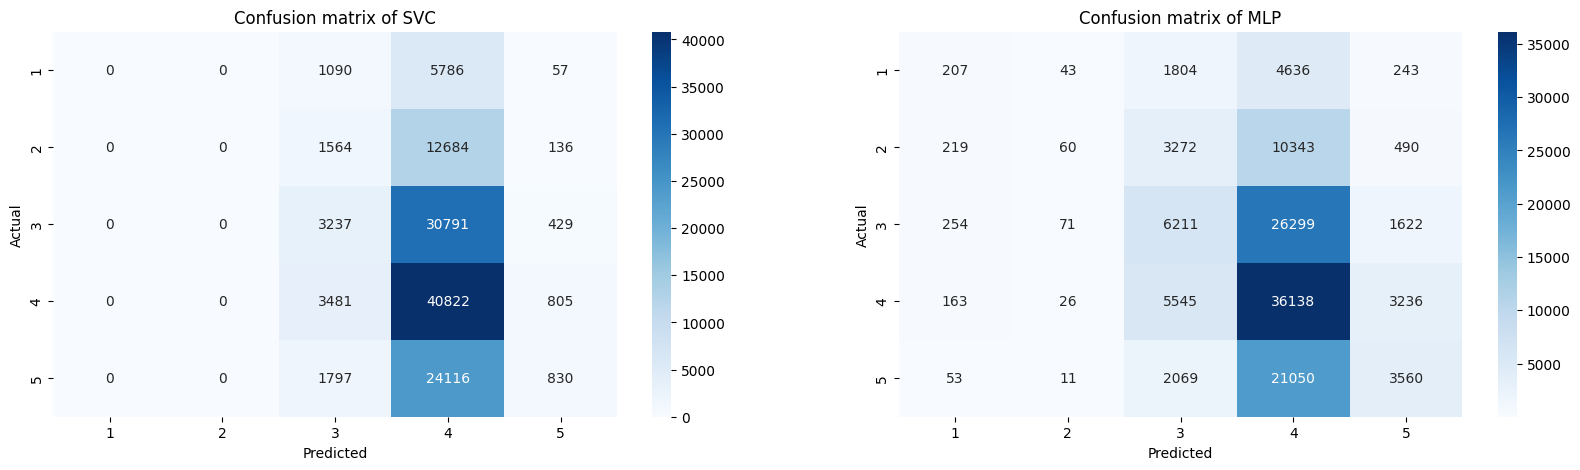

In [283]:
# taken complitely from PA2

def make_confision_matrix(y_true, y_pred):
    return pd.crosstab(y_true, y_pred)

cm_svc = make_confision_matrix(y_test, svc_pipe.predict(X_test))
for k in range(1, 6):
    if k not in cm_svc.columns:
        cm_svc[k] = np.zeros(len(cm_svc), dtype=int)
cm_svc = cm_svc.reindex(sorted(cm_svc.columns), axis=1)

cm_mlp = make_confision_matrix(y_test, mlp_pipe.predict(X_test))


fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.heatmap(
    cm_svc, 
    annot=True, fmt='d', cmap='Blues', ax=ax[0]
    )
ax[0].set_title('Confusion matrix of SVC')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(
    cm_mlp, 
    annot=True, fmt='d', cmap='Blues', ax=ax[1]
    )
ax[1].set_title('Confusion matrix of MLP')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')


In [290]:
def compute_accuracy_from_cm(cm):
    return np.trace(cm) / cm.values.sum()

def comute_per_class_accuracy(cm):
    res = pd.Series(np.diag(cm) / cm.sum(axis=1))
    res.index = cm.index
    res = res.round(3)
    return res

print(f"accuracy of SVC: {compute_accuracy_from_cm(cm_svc):.2%}")
print(f"accuracy of MLP: {compute_accuracy_from_cm(cm_mlp):.2%}")

print(f"Per class accuracy of SVC:\n{comute_per_class_accuracy(cm_svc)}")
print(f"Per class accuracy of MLP:\n{comute_per_class_accuracy(cm_mlp)}")

accuracy of SVC: 35.17%
accuracy of MLP: 36.18%
Per class accuracy of SVC:
Rating
1    0.000
2    0.000
3    0.094
4    0.905
5    0.031
dtype: float64
Per class accuracy of MLP:
Rating
1    0.030
2    0.004
3    0.180
4    0.801
5    0.133
dtype: float64


There are 2 main observations:
1. for some reason svc is not predicting 1 and 2. I would say that its because there are a small amount of 1 and 2 ratings and model profit more from predicting 3, 4 and 5.
2. For the same reason, we can see that class accuracy is high got 4, but low for all other classes on both models. MLP has highet accuracy as it better predicts 3 and 5 class.


# Task 2: MLP Classifier
(maximum achievable points: 40)  
In this task you will implement a multi-layer perceptron (MLP) for classification, the finite-differences approach for approximately computing the gradient of the loss with respect to the weights of the MLP, and train the MLP using the Adam optimizer (which is a variant of SGD that uses individual learning rates for each parameter). We consider the perceptron loss as our loss function.

Hint: Read the whole description of this task before starting to code. Think about how you can implement a MLP in a modular fashion such that you can easily change the number of layers and activation functions.

The matrices x_train and x_test have the following shapes: (number of samples) × (number of features). The matrices y_train and y_test have the following shapes: (number of samples) × (number of targets). Normalize the data with the MinMaxScaler.
□ Report the dataset statistics (number of features and training and test samples, num- ber of targets).


In [13]:
hf = h5py.File('classification.h5', 'r')
x_train = np.array(hf.get('x_train'))
y_train = np.array(hf.get('y_train'))
x_test = np.array(hf.get('x_test'))
y_test = np.array(hf.get('y_test'))
hf.close()

In [14]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((500, 2), (500, 1), (10000, 2), (10000, 1))

In [15]:
y_train[y_train == 0] = -1
y_test[y_test == 0] = -1

In [16]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

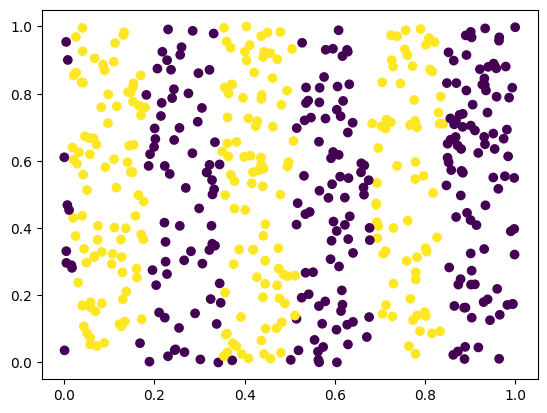

In [17]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='viridis')

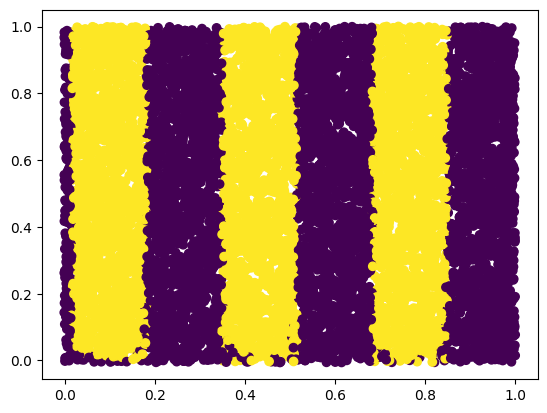

In [18]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='viridis')

# Subtask 2: Forward Propagation
(9 points)
Implement forward propagation for an MLP classifier with two hidden layers and ReLU activation functions, except for the output layer which does not have an   activation function (or equivalently uses the identity as the activation function). Use small hidden layers, each containing 10 neurons. The MLP must have a single   output. Initialize weights randomly as discussed in class. Initialize biases as all-zero vectors.  
□ Briefly describe your implementation. How do you store the weights and biases? Hint: Maintain lists of weight matrices and biases vectors so that you can easily evaluate different neural network architectures.  
Hint: In the next subtask we will replace the activation functions by other activation functions, so keep the activation function modular.  

In [64]:
class BinaryMLP:
    def __init__(self, n_inputs, n_hidden, num_layers, activation, eps=1e-6):
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = 1

        self.eps = eps

        # activation
        self.activation = activation
        # multiplyer for weights initialization
        if activation.__name__ == 'ReLU':
            multiplyer = lambda n_in, n_out: np.sqrt(2 / n_in) # he
        else:
            multiplyer = lambda n_in, n_out: np.sqrt(2 / (n_in + n_out)) # glorot
            multiplyer = lambda n_in, n_out: 1 # glorot

        # weights and biases
        self.layers = [
            np.random.randn(self.n_inputs, self.n_hidden) * multiplyer(self.n_inputs, self.n_hidden)
            ]
        self.biases = [np.zeros((1, self.n_hidden))]
        for i in range(num_layers):
            self.layers.append(
                np.random.randn(self.n_hidden, self.n_hidden) \
                    * multiplyer(self.n_hidden, self.n_hidden)
                )
            self.biases.append(np.zeros((1, self.n_hidden)))
        self.layers.append(
            np.random.randn(self.n_hidden, self.n_outputs) \
                * multiplyer(self.n_hidden, self.n_outputs)
            )
        self.biases.append(np.zeros((1, self.n_outputs)))

    def forward(self, x):
        # going through all layers
        for i in range(len(self.layers) - 1):
            x = np.dot(x, self.layers[i]) + self.biases[i]
            x = self.activation(x)
        x = np.dot(x, self.layers[-1]) + self.biases[-1]
        return x

    def loss(self, y_true, y_pred):
        # hinge loss
        return np.mean(np.maximum(0, 1 - y_true * y_pred))

    def grad_layer(self, x, y, i):
        # grad over i layer 
        grad = np.zeros_like(self.layers[i])
        for j in range(self.layers[i].shape[0]):
            for k in range(self.layers[i].shape[1]):
                # + eps
                self.layers[i][j][k] = self.layers[i][j][k] + self.eps
                l1 = self.loss(y, self.forward(x))
                # - eps
                self.layers[i][j][k] = self.layers[i][j][k] - 2 * self.eps
                l2 = self.loss(y, self.forward(x))
                # return to original weights
                self.layers[i][j][k] = self.layers[i][j][k] + self.eps 
                # print(l1)
                grad[j][k] = (l1 - l2) / (2 * self.eps)
        return grad

    def grad_bias(self, x, y, i):
        # grad over i bias
        grad = np.zeros_like(self.biases[i])
        for k in range(self.biases[i].shape[0]):
            # + eps
            self.biases[i][k] = self.biases[i][k] + self.eps
            l1 = self.loss(y, self.forward(x))
            # - eps
            self.biases[i][k] = self.biases[i][k] - 2 * self.eps
            l2 = self.loss(y, self.forward(x))
            # return to original weights
            self.biases[i][k] = self.biases[i][k] + self.eps
            grad[k] = (l1 - l2) / (2 * self.eps)
        return grad
    
    def grad(self, x, y):
        # computes list of gradients over layers and biases
        grads_layers = []
        for i in range(len(self.layers)):
            grads_layers.append(self.grad_layer(x, y, i))

        grads_biases = []
        for i in range(len(self.layers)):
            grads_biases.append(self.grad_bias(x, y, i))
        return grads_layers, grads_biases

    def predict(self, x):
        # predicting class by giving sign
        return np.sign(self.forward(x))

### 1 architecture

In [69]:
def ReLU(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

input_dim = x_train.shape[1]
hidden_dim = 25
output_dim = 1
num_hidden = 5
lr = 5e-2

mlp = BinaryMLP(input_dim, hidden_dim, num_hidden, ReLU)
adam = AdamOptimizer(mlp.layers + mlp.biases, lr, 0.9, 0.999, 1e-08)

mlp.forward(x_train).shape

(500, 1)

In [70]:
num_epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    g = mlp.grad(x_train, y_train)
    adam.update_params(mlp.layers + mlp.biases, g[0] + g[1])
    y_pred = mlp.forward(x_train)
    train_loss = mlp.loss(y_train, y_pred)
    test_loss = mlp.loss(y_test, mlp.forward(x_test)) 
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(accuracy_score(y_train, mlp.predict(x_train)))
    test_accuracies.append(accuracy_score(y_test, mlp.predict(x_test)))
    print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {train_loss}, Test loss: {test_loss}")
    print(f"test accuracy: {accuracy_score(y_train, mlp.predict(x_train))}")
    print(f"test accuracy: {accuracy_score(y_test, mlp.predict(x_test))}")

Epoch 1/100, Train loss: 0.9823733395587172, Test loss: 0.9918426626654088
test accuracy: 0.488
test accuracy: 0.4842
Epoch 2/100, Train loss: 1.0066036304929997, Test loss: 1.0454955093404497
test accuracy: 0.488
test accuracy: 0.4842
Epoch 3/100, Train loss: 0.9821179004420533, Test loss: 0.9875069975527474
test accuracy: 0.488
test accuracy: 0.4842
Epoch 4/100, Train loss: 0.9966875871688037, Test loss: 0.997760110157879
test accuracy: 0.488
test accuracy: 0.4842
Epoch 5/100, Train loss: 1.0000243187187134, Test loss: 1.0006296957217695
test accuracy: 0.488
test accuracy: 0.4842
Epoch 6/100, Train loss: 0.9994963041958731, Test loss: 1.0001503200165935
test accuracy: 0.488
test accuracy: 0.4842
Epoch 7/100, Train loss: 0.9952988125462903, Test loss: 0.9963001618459859
test accuracy: 0.488
test accuracy: 0.4842
Epoch 8/100, Train loss: 0.9853431424219448, Test loss: 0.9876771082388607
test accuracy: 0.488
test accuracy: 0.4842
Epoch 9/100, Train loss: 0.9843446354990452, Test loss: 0

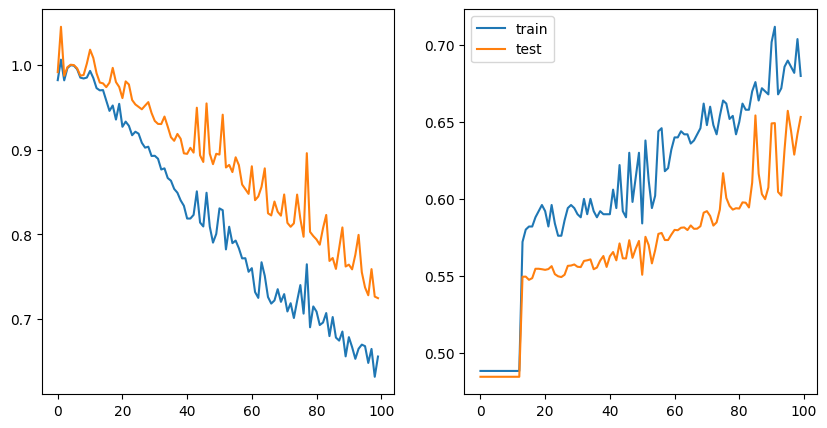

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[1].plot(train_accuracies, label='train')
ax[1].plot(test_accuracies, label='test')
plt.legend()

### 2 architecture

In [65]:
def ReLU(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

input_dim = x_train.shape[1]
hidden_dim = 50
output_dim = 1
num_hidden = 3
lr = 1e-2
mlp = BinaryMLP(input_dim, hidden_dim, num_hidden, sigmoid)

adam = AdamOptimizer(mlp.layers + mlp.biases, lr, 0.9, 0.999, 1e-08)


mlp.forward(x_train).shape

(500, 1)

In [66]:
num_epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    g = mlp.grad(x_train, y_train)
    adam.update_params(mlp.layers + mlp.biases, g[0] + g[1])
    y_pred = mlp.forward(x_train)
    train_loss = mlp.loss(y_train, y_pred)
    test_loss = mlp.loss(y_test, mlp.forward(x_test)) 
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(accuracy_score(y_train, mlp.predict(x_train)))
    test_accuracies.append(accuracy_score(y_test, mlp.predict(x_test)))
    print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {train_loss}, Test loss: {test_loss}")
    print(f"test accuracy: {accuracy_score(y_train, mlp.predict(x_train))}")
    print(f"test accuracy: {accuracy_score(y_test, mlp.predict(x_test))}")

Epoch 1/50, Train loss: 3.114026395688748, Test loss: 3.0707432382858983
test accuracy: 0.512
test accuracy: 0.5158
Epoch 2/50, Train loss: 1.7760949382342053, Test loss: 1.7372923260869018
test accuracy: 0.512
test accuracy: 0.5158
Epoch 3/50, Train loss: 1.1155852711328702, Test loss: 1.0772274094056764
test accuracy: 0.362
test accuracy: 0.4089
Epoch 4/50, Train loss: 1.5029107424814994, Test loss: 1.5031195783702496
test accuracy: 0.488
test accuracy: 0.4842
Epoch 5/50, Train loss: 1.6599088074444934, Test loss: 1.6622794984355882
test accuracy: 0.488
test accuracy: 0.4842
Epoch 6/50, Train loss: 1.505027022587276, Test loss: 1.5065539585273622
test accuracy: 0.488
test accuracy: 0.4842
Epoch 7/50, Train loss: 1.1794832487755442, Test loss: 1.1790074015244623
test accuracy: 0.488
test accuracy: 0.4842
Epoch 8/50, Train loss: 1.0515367609705022, Test loss: 1.0396262088762922
test accuracy: 0.488
test accuracy: 0.4842
Epoch 9/50, Train loss: 1.0286936958700268, Test loss: 1.016431786

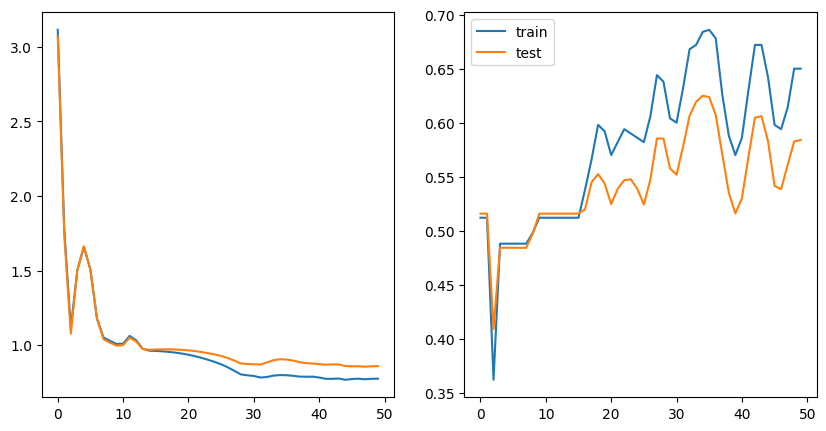

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[1].plot(train_accuracies, label='train')
ax[1].plot(test_accuracies, label='test')
plt.legend()

## Subtask 4: Model training using PyTorch
(10 points)
Remark: For this task you can use PyTorch library (torch).
PyTorch is a popular library for developing deep learning models. Install PyTorch and use it to train a neural network with the same architectures as in the previous subtask. To this end, you might find it helpful to quickly work through a PyTorch tutorial, e.g., this one.  
□ Report plots showing the mean hinge loss on the training and test data during training for all tested architectures (test at least 2). Also report the classification accuracy during training on training and test data.  
□ Do you observe any differences in performance for the different architectures and activation functions?  
□ Do you observe a difference in performance between the PyTorch-based models and your custom implementation of neural networks?  


In [72]:
# reload data just in case
hf = h5py.File('classification.h5', 'r')
x_train = np.array(hf.get('x_train'))
y_train = np.array(hf.get('y_train'))
x_test = np.array(hf.get('x_test'))
y_test = np.array(hf.get('y_test'))
hf.close()

In [73]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((500, 2), (500, 1), (10000, 2), (10000, 1))

In [74]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

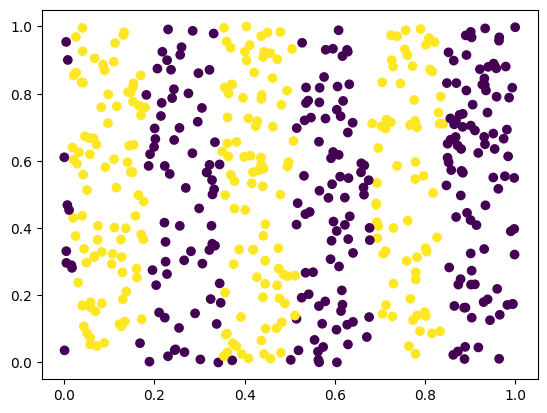

In [75]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='viridis')

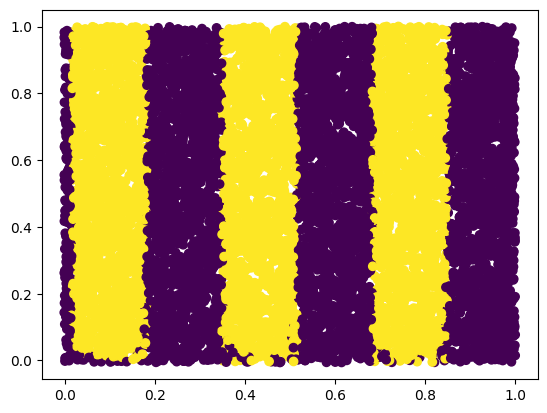

In [76]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='viridis')

In [77]:
class MLP_torch(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_hidden, activation_layer):
        super(MLP_torch, self).__init__()
        self.layers = []
        self.layers.append(nn.Linear(input_dim, hidden_dim, bias=True))
        self.layers.append(activation_layer())
        for i in range(num_hidden):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim, bias=True))
            self.layers.append(activation_layer())
        self.layers.append(nn.Linear(hidden_dim, output_dim, bias=True))
        self.layers = nn.ModuleList(self.layers)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### 1 architecture

In [80]:
input_dim = x_train.shape[1]
hidden_dim = 25
output_dim = 1
num_hidden = 5
lr = 5e-2

mlp_torch = MLP_torch(input_dim, output_dim, hidden_dim, num_hidden, nn.ReLU)
loss_function = HingeLoss(task='binary')
optimizer = torch.optim.Adagrad(mlp_torch.parameters(), lr=lr)

In [81]:
dataset = data_utils.TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
trainloader = data_utils.DataLoader(dataset, batch_size=x_train.shape[0], shuffle=True, num_workers=1)
dataset = data_utils.TensorDataset(torch.tensor(x_test), torch.tensor(y_test))
testloader = data_utils.DataLoader(dataset, batch_size=x_test.shape[0], shuffle=True, num_workers=1)

current_loss_train = []
current_loss_test = []

accuracy_train = []
accuracy_test = []

for epoch in range(0, 50):
    print(f'Starting Epoch {epoch+1}')    
    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        # targets = targets.reshape(-1)

        optimizer.zero_grad()

        outputs = mlp_torch(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        outputs = (torch.sign(outputs).detach().numpy() + 1) / 2
        accuracy_train.append(accuracy_score(outputs, targets.detach().numpy()))
        current_loss_train.append(loss.item())


    for i, data in enumerate(testloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        # targets = targets.reshape(-1)

        outputs = mlp_torch(inputs)

        loss = loss_function(outputs, targets)

        current_loss_test.append(loss.item())
        outputs = (torch.sign(outputs).detach().numpy() + 1) / 2
        # print(outputs)
        # print(targets)
        accuracy_test.append(accuracy_score(outputs, targets.detach().numpy()))

    print(f'Loss after epoch train: {current_loss_train[-1]}, \
        Loss after epoch test: {current_loss_test[-1]}, \
        accuracy train {accuracy_train[-1]}, accuracy test {accuracy_test[-1]}')

print("Training has completed")

Starting Epoch 1
Loss after epoch train: 1.012008547782898,         Loss after epoch test: 1.0128211975097656,         accuracy train 0.512, accuracy test 0.5158
Starting Epoch 2
Loss after epoch train: 1.009667158126831,         Loss after epoch test: 1.0047825574874878,         accuracy train 0.512, accuracy test 0.5158
Starting Epoch 3
Loss after epoch train: 1.0020655393600464,         Loss after epoch test: 0.9971103668212891,         accuracy train 0.512, accuracy test 0.5158
Starting Epoch 4
Loss after epoch train: 0.9954225420951843,         Loss after epoch test: 1.0111666917800903,         accuracy train 0.512, accuracy test 0.5158
Starting Epoch 5
Loss after epoch train: 1.008205533027649,         Loss after epoch test: 0.9924076199531555,         accuracy train 0.512, accuracy test 0.5158
Starting Epoch 6
Loss after epoch train: 0.982837975025177,         Loss after epoch test: 0.9922372102737427,         accuracy train 0.512, accuracy test 0.5158
Starting Epoch 7
Loss afte

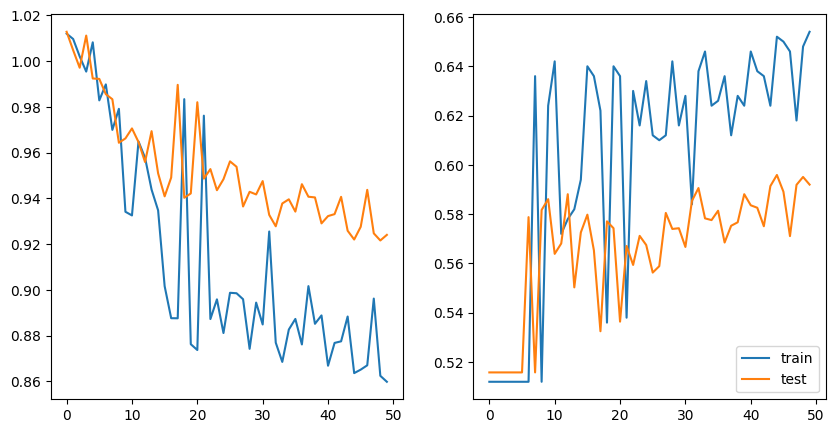

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(current_loss_train, label='train')
ax[0].plot(current_loss_test, label='test')
ax[1].plot(accuracy_train, label='train')
ax[1].plot(accuracy_test, label='test')
plt.legend()

### 2nd architecture

In [85]:
input_dim = x_train.shape[1]
hidden_dim = 50
output_dim = 1
num_hidden = 3
lr = 1e-2

mlp_torch = MLP_torch(input_dim, output_dim, hidden_dim, num_hidden, nn.Sigmoid)
loss_function = HingeLoss(task='binary')
optimizer = torch.optim.Adagrad(mlp_torch.parameters(), lr=lr)

In [86]:
dataset = data_utils.TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
trainloader = data_utils.DataLoader(dataset, batch_size=x_train.shape[0], shuffle=True, num_workers=1)
dataset = data_utils.TensorDataset(torch.tensor(x_test), torch.tensor(y_test))
testloader = data_utils.DataLoader(dataset, batch_size=x_test.shape[0], shuffle=True, num_workers=1)

current_loss_train = []
current_loss_test = []

accuracy_train = []
accuracy_test = []

for epoch in range(0, 50):
    print(f'Starting Epoch {epoch+1}')    
    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        # targets = targets.reshape(-1)

        optimizer.zero_grad()

        outputs = mlp_torch(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        outputs = (torch.sign(outputs).detach().numpy() + 1) / 2
        accuracy_train.append(accuracy_score(outputs, targets.detach().numpy()))
        current_loss_train.append(loss.item())


    for i, data in enumerate(testloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        # targets = targets.reshape(-1)

        outputs = mlp_torch(inputs)

        loss = loss_function(outputs, targets)

        current_loss_test.append(loss.item())
        outputs = (torch.sign(outputs).detach().numpy() + 1) / 2
        # print(outputs)
        # print(targets)
        accuracy_test.append(accuracy_score(outputs, targets.detach().numpy()))

    print(f'Loss after epoch train: {current_loss_train[-1]}, \
        Loss after epoch test: {current_loss_test[-1]}, \
        accuracy train {accuracy_train[-1]}, accuracy test {accuracy_test[-1]}')

print("Training has completed")

Starting Epoch 1
Loss after epoch train: 1.0105006694793701,         Loss after epoch test: 1.015258550643921,         accuracy train 0.488, accuracy test 0.5158
Starting Epoch 2
Loss after epoch train: 1.011580228805542,         Loss after epoch test: 1.0142462253570557,         accuracy train 0.512, accuracy test 0.5158
Starting Epoch 3
Loss after epoch train: 1.0108073949813843,         Loss after epoch test: 1.0132379531860352,         accuracy train 0.512, accuracy test 0.5158
Starting Epoch 4
Loss after epoch train: 1.0100358724594116,         Loss after epoch test: 1.0122495889663696,         accuracy train 0.512, accuracy test 0.5158
Starting Epoch 5
Loss after epoch train: 1.0092777013778687,         Loss after epoch test: 1.0112990140914917,         accuracy train 0.512, accuracy test 0.5158
Starting Epoch 6
Loss after epoch train: 1.0085471868515015,         Loss after epoch test: 1.0104031562805176,         accuracy train 0.512, accuracy test 0.5158
Starting Epoch 7
Loss af

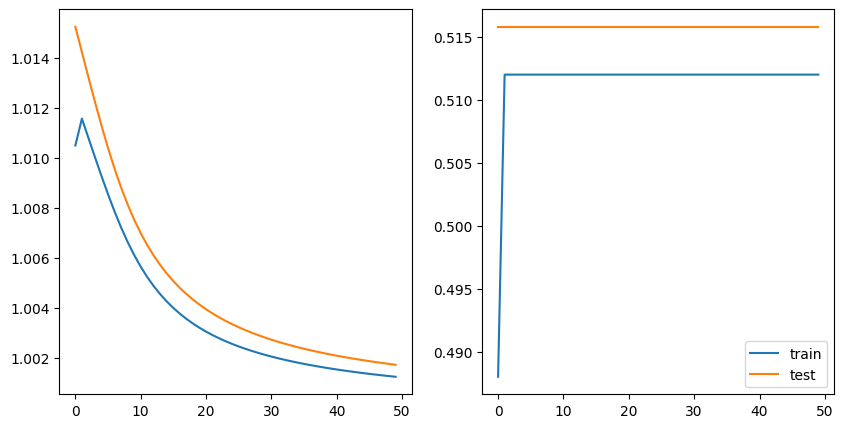

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(current_loss_train, label='train')
ax[0].plot(current_loss_test, label='test')
ax[1].plot(accuracy_train, label='train')
ax[1].plot(accuracy_test, label='test')
plt.legend()

Time results:  
Self-implemented:  
- Architecture 1: 2min5sec
- Architecture 2: 6min25sec

Torch:
- Architecture 1: 1min8sec
- Architecture 2: 1min9sec

Observatins
- Torch implementation is well-optimized, so it is faster than self-implemented.  
- Results howewever are not as good as self-implemented, but I think that on long-distance training it would be better as its not approximating derivative.
- sigmoid would be worse time-wise, as it contains exp function, but here we cannot compare as it has dfferent architecture.